In [1]:
#!pip install pykml
#!pip install pyshp

In [2]:
import pandas as pd
from pykml.factory import KML_ElementMaker as KML
from lxml import etree
import shapefile as shp
import matplotlib.pyplot as plt
import numpy as np

In [3]:
file_name = 'relatorio_629.csv'

In [4]:
df = pd.read_csv(filepath_or_buffer=file_name, sep=';', encoding= 'unicode_escape')

In [5]:
filtro_intervencao = df['Tipo de Intervenção'] == 'Cadastro apenas da barragem'
filtro_status1 = df['Status'] != 'Concluído'
filtro_status2 = df['Status'] != 'Desativado'
filtro_status3 = df['Status'] != 'Em andamento'

In [6]:
df_filtrado = df[filtro_status1 & filtro_status2 & filtro_status3 & filtro_intervencao]

In [7]:
df_filtrado.shape

(89, 54)

In [8]:
df_filtrado.head()

,Número do cadastro,Número da portaria,Nome do usuário de água,CPF/CNPJ,Natureza da intervenção,Tipo da Fonte de Captação,Tipo de Intervenção,Classificação,Status,Observação,...,Nº da licença,Nome do responsável técnico,CPF do responsável técnico,Formação do responsável técnico,Número da ART do responsável técnico,Nome da Geometria,Latitude,Longitude,Latitude (ponto final),Longitude (ponto final)
1,2020/005.099,-,BT GERADORA DE ENERGIA ELETRICA S.A.,03.149.173/0001-64,Água Superficial,Barragem de nível,Cadastro apenas da barragem,Cadastro,Aguardando formalização de documentos,-,...,-,Karl Rischbieter,003.791.409-00,Engenharia Elétrica,2102702-0,Ponto 1,"-53,5789","-27,5612",-,-
7,2020/002.866,-,LINHA ONZE OESTE ENERGIA LTDA,27.059.624/0001-30,Água Superficial,Barragem de nível,Cadastro apenas da barragem,Cadastro,Aguardando formalização de documentos,-,...,-,Daniel Zonta,008.515.139-48,Engenharia Civil,-,Ponto 1,"-54,0045500199785","-28,3511124417778",-,-
8,2020/002.683,-,Cooperativa de Geração de Energia e Desenvolvi...,08.290.060/0001-06,Água Superficial,Barragem de nível,Cadastro apenas da barragem,Cadastro,Aguardando formalização de documentos,-,...,-,Karl Rischbieter,003.791.409-00,Engenharia Elétrica,9335010033,Ponto 1,"-53,9701307613505","-27,9612491935233",-,-
12,2020/001.754,-,BORTOLON AGROCOMERCIAL EIRELI,00.376.956/0001-92,Água Superficial,Barragem de acumulação,Cadastro apenas da barragem,Cadastro,Aguardando alterações de dados inconsistentes,-,...,-,Edesio Alvaro Bortolon,385.825.890-34,Engenharia Civil,-,Ponto 1,"-50,8559701377817","-28,2990821433521",-,-
13,2020/001.523,-,ENERBIO SERVICOS DE ENGENHARIA LTDA,05.385.865/0001-37,Água Superficial,Barragem de nível,Cadastro apenas da barragem,Cadastro,Aguardando alterações de dados inconsistentes,-,...,-,Rafael André Wiest,989.773.420-15,Engenharia Civil,-,Ponto 1,"-53,5472","-27,4186",-,-


In [9]:
aguardando = df_filtrado[df_filtrado['Status'] == 'Aguardando análise'][['Número do cadastro', 'Nome do usuário de água', 'Data de início do cadastro', 'Data de saída do processo']]
aguardando['Data de saída do processo'] = pd.to_datetime(aguardando['Data de saída do processo'], dayfirst=True)
aguardando['Data de início do cadastro'] = pd.to_datetime(aguardando['Data de início do cadastro'], dayfirst=True)
aguardando.sort_values('Data de saída do processo')
aguardando.to_csv('aguardando_analise.csv', index=False)
aguardando

,Número do cadastro,Nome do usuário de água,Data de início do cadastro,Data de saída do processo
57,2019/013.226,COOPERATIVA DE DISTRIBUICAO E GERACAO DE ENERG...,2019-07-22,2019-07-22
94,2019/005.142,TOUROS IV ENERGÉTICA S.A.,2019-04-01,2020-02-14
270,2017/030.507,Aecogeo Soluções Ambientais Ltda,2017-09-28,2020-04-03
338,2016/007.777,TRES FRONTEIRAS GERAÇÃO DE ENERGIA,2016-06-20,2019-10-14


In [10]:
shp_path = "estados_2010.shp"
sf = shp.Reader(shp_path)

In [11]:
sf.records()[22]

Record #22: [23, 'Rio Grande do Sul', 'RS', '1', '43']

In [12]:
def plot_shape(idt, ax, sf):
    shape_ex = sf.shape(idt)
    x_lon = np.zeros((len(shape_ex.points),1))
    y_lat = np.zeros((len(shape_ex.points),1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
    ax.plot(x_lon,y_lat,c='gray') 
    x0 = np.mean(x_lon)
    y0 = np.mean(y_lat)

In [13]:
pie_dict = {}
for s in df_filtrado['Status'].unique():
    ns = sum(df_filtrado['Status'] == s)
    pie_dict[s] = ns

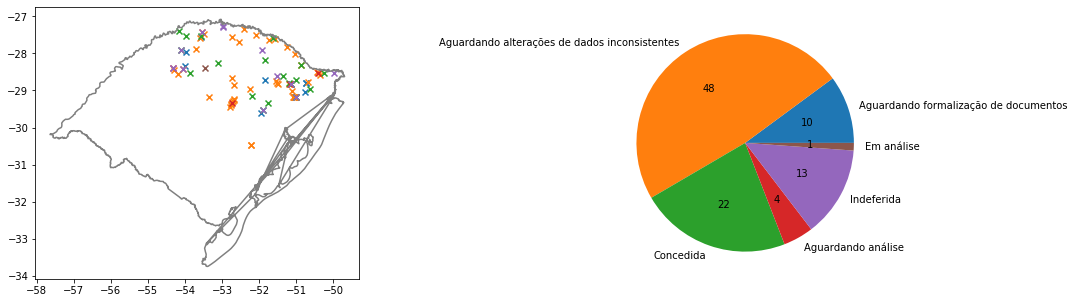

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))
ax2.pie(pie_dict.values(), autopct='%1.0f', labels=pie_dict.keys())
plot_shape(22, ax1, sf)
for s in df_filtrado['Status'].unique():
    f = df_filtrado['Status'] == s
    x, y = df_filtrado[f]['Latitude'].values, df_filtrado[f]['Longitude'].values
    x, y = [float(i.replace(',','.')) for i in x], [float(i.replace(',','.')) for i in y]
    ax1.scatter(x, y, label = s, marker='x')
ax1.axis('scaled')
#fig.suptitle('Status dos processos de hidrelétricas do SIOUT')
#ax2.legend(loc='upper right')
plt.savefig('Status', bbox_inches='tight')

In [15]:
doc = KML.Document()

In [16]:
icons = {
    'verde':'http://maps.google.com/mapfiles/kml/pushpin/grn-pushpin.png',
    'amarelo':'http://maps.google.com/mapfiles/kml/pushpin/ylw-pushpin.png',
    'vermelho':'http://maps.google.com/mapfiles/kml/pushpin/red-pushpin.png'
}

In [17]:
for color in icons:
    
    s = KML.Style(
            KML.IconStyle(
                KML.scale(1.2),
                KML.Icon(
                    KML.href(icons[color])
                ),
            ),
            id=color,
        )
    
    doc.append(s)

In [18]:
fld_ag_doc = KML.Folder(KML.name('Aguardando formalização de documentos'))
fld_ag_an = KML.Folder(KML.name('Aguardando análise'))
fld_ag_alt = KML.Folder(KML.name('Aguardando alterações de dados inconsistentes'))
fld_an = KML.Folder(KML.name('Em análise'))
fld_conc = KML.Folder(KML.name('Concedida'))
fld_ind = KML.Folder(KML.name('Indeferida'))

In [19]:
for index, row in df_filtrado.iterrows():
    name = row['Número do cadastro']
    usuario = row['Nome do usuário de água']
    status = row['Status']
    corpo_hidrico = row['Corpo Hídrico']
    municipio = row['Município']
    description = '''
Usuario: {}
Status: {}
Municipio: {}
Corpo Hidrico: {}
    '''.format(usuario, status, municipio, corpo_hidrico)
    lat = row['Latitude'].replace(',','.')
    long = row['Longitude'].replace(',','.')
    coordinates = lat+','+long
    
    if status == 'Concedida':
        style = '#verde'
    elif status == 'Indeferida':
        style = '#vermelho'
    else:
        style = '#amarelo'
    
    p = KML.Placemark(
        KML.name(name),
        KML.Point(KML.coordinates(coordinates)),
        KML.description(description),
        KML.styleUrl(style))
    
    if status == 'Aguardando formalização de documentos':
        fld_ag_doc.append(p)
    elif status == 'Aguardando análise':
        fld_ag_an.append(p)
    elif status == 'Aguardando alterações de dados inconsistentes':
        fld_ag_alt.append(p)
    elif status == 'Em análise':
        fld_an.append(p)
    elif status == 'Concedida':
        fld_conc.append(p)
    elif status == 'Indeferida':
        fld_ind.append(p)

In [20]:
doc.append(fld_ag_doc)
doc.append(fld_ag_an)
doc.append(fld_ag_alt)
doc.append(fld_an)
doc.append(fld_conc)
doc.append(fld_ind)

In [21]:
kml_file_path = 'hidreletricas_SIOUT.kml'

In [22]:
kml_str = etree.tostring(doc, pretty_print=True).decode('utf-8')

In [23]:
f = open(kml_file_path, "w")
f.write(kml_str)
f.close()